In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# data input
data = pd.read_csv("calhabs_sst_chl_rrs_sio.csv")
data.head

# summing the two Pseudo-nitzschia species
data["Pn_total"] = data["Pn_delicatissima"].add(data["Pn_seriata"], fill_value=0)
data[["Pn_delicatissima", "Pn_seriata", "Pn_total"]]
#print(data["Pn_total"].to_list())

,Pn_delicatissima,Pn_seriata,Pn_total
0,1252.0,0.0,1252.0
1,13768.0,6884.0,20652.0
2,4381.0,4381.0,8762.0
3,13142.0,6884.0,20026.0
4,1252.0,0.0,1252.0
...,...,...,...
92,2461.0,821.0,3282.0
93,NaN,NaN,NaN
94,NaN,NaN,NaN
95,6258.0,1252.0,7510.0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Column names of the Rrs bands to combine
wavelength1 = "Rrs_380.0"
wavelength2 = "Rrs_442.0"

# Simple environmental predictors
ENV_VARS = ["sst", "chlor_a"]

data2 = data[data["Pn_total"].notna()].copy() #Create copy of data by keeping only rows of data where Np_total has a value (is not NA).

# Create a new column in df for the ratio
Rrs_ratio = f"ndi_{wavelength1}_{wavelength2}"
data2[Rrs_ratio] = (data2[wavelength1] - data2[wavelength2]) / (data2[wavelength1] + data2[wavelength2])

predictors = [Rrs_ratio] + ENV_VARS
# To see what the model would look like without PACE, use:
#predictors = ENV_VARS
X = data2[predictors]
#y = data2["Pn_total"]
y = np.log10(data2["Pn_total"])

# Get rid of NaNs, BRT gets mad otherwise (Keep only the rows where every column in X is non-NA and non-Inf, and apply the exact same row filtering to y.)
mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y)

X = X.loc[mask].copy()
y = y.loc[mask].copy()

print(f"Predictors used: {predictors}")
print(f"Number of samples: {len(y)}")

Predictors used: ['ndi_Rrs_380.0_Rrs_442.0', 'sst', 'chlor_a']
Number of samples: 79


/srv/conda/envs/notebook/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Boosted Regression Tree setup

First, we’ll split the dataset into training and testing subsets using train_test_split. Here, test_size=0.2 means that 20% of the data are held out for testing, while the remaining 80% are used to train the model. The random_state=42 just fixes the random seed so the split is reproducible; using 42 is arbitrary (the answer to the universe and everything), but it ensures we get the same results every time we run the code. Remove random_state if you want the results to change with every run.



In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train)

66    4.635293
81    3.097604
84    4.176641
2     3.942603
13    3.574610
        ...   
55    5.238916
70    4.504008
77    4.138871
20    5.500547
48    3.574610
Name: Pn_total, Length: 63, dtype: float64


Next, we’ll set up a boosted regression tree using GradientBoostingRegressor. This model builds an ensemble of many shallow decision trees (n_estimators=800, max_depth=3), added sequentially so that each new tree focuses on correcting errors made by the previous ones. The small learning_rate=0.01 slows the learning process to improve generalization, while subsample=0.8 introduces randomness by training each tree on 80% of the data, which helps reduce overfitting. We again set random_state=42 to keep the model behavior reproducible.

In [12]:
brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=18)
#brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8)
brt.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",800
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

After fitting the model to the training data, we use it to predict the held-out test data. Model performance is then evaluated using Pearson’s correlation coefficient (r), the coefficient of determination (R²), the root mean squared error (RMSE), and the median absolute percent error (MdAPE) giving us a quick sense of how well the model captures both the strength of the relationship and the overall prediction error.

In [13]:
y_pred = brt.predict(X_test)

r = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)

# For error metrics, let's get back in linear space so we can interpret
#y_test_lin = y_test #for non-log10 
#y_pred_lin = y_pred #for non-log10
y_test_lin = 10 ** y_test #for log10 
y_pred_lin = 10 ** y_pred #for log10 
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mdape = np.median(np.abs((y_pred_lin - y_test_lin) / y_test_lin)) * 100

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")
print(f"BRT RMSE (linear space)   : {rmse_lin:.3f} cells/L")
print(f"BRT MdAPE (linear space)   : {mdape:.1f}%")

BRT Pearson r : 0.251
BRT R²        : -0.519
BRT RMSE (linear space)   : 32786.397 cells/L
BRT MdAPE (linear space)   : 123.0%


Finally, let’s visualize how well the model is doing and see which predictors the BRT relied on most. We’ll make a scatter plot of observed vs. predicted values as well as a STAR plot of "feature" importance.

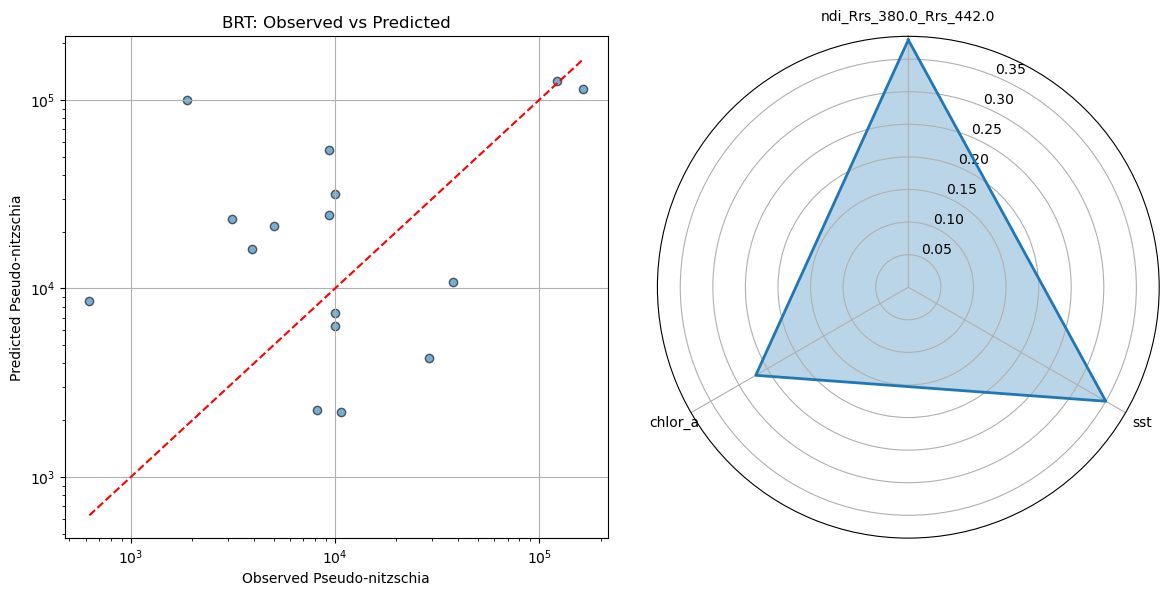

In [14]:
# Prepare data for STAR plot
importances = brt.feature_importances_
importances = importances / importances.sum()
labels = predictors
angles = np.linspace(0, 2 * np.pi, len(importances), endpoint=False)

# Close the loop for polar plot
angles = np.concatenate([angles, angles[:1]])
importances_plot = np.concatenate([importances, importances[:1]])

# Create side-by-side figure
fig = plt.figure(figsize=(12, 6))

# Scatter plot (left)
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_test_lin, y_pred_lin, alpha=0.6, edgecolor="k")
ax1.plot([y_test_lin.min(), y_test_lin.max()], [y_test_lin.min(), y_test_lin.max()], "r--")
ax1.set_xlabel("Observed Pseudo-nitzschia")
ax1.set_ylabel("Predicted Pseudo-nitzschia")
ax1.set_title("BRT: Observed vs Predicted")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)

# Polar plot (right)
ax2 = fig.add_subplot(1, 2, 2, polar=True)
ax2.plot(angles, importances_plot, linewidth=2)
ax2.fill(angles, importances_plot, alpha=0.3)
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(labels)
#ax2.set_title("BRT Feature Importance", pad=25)

plt.tight_layout()
plt.show()

